<a href="https://colab.research.google.com/github/ruby199/pytorch/blob/main/08_pytorch_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating - ViT


The goal of ML resaerch paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (BiT) architechure/paper with pytorch

https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/08_pytorch_paper_replicating.ipynb#scrollTo=873828f0-e50f-40b9-9879-f9a01adaa020


## 0. Getting Setup


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3881, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 3881 (delta 979), reused 943 (delta 932), pack-reused 2831
Receiving objects: 100% (3881/3881), 647.98 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (2272/2272), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.
Namely, the pizza, steak and sushi images we've been trying so far.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [7]:
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"M<anually created transforms: {manual_transforms}")

M<anually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardward... can always scale up later)

BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
 )

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

Visualize, visualize, visualize!

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

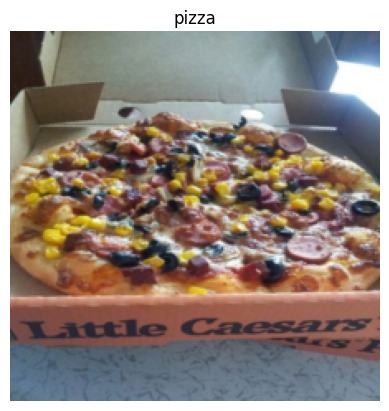

In [10]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

### 3.1 Inputs and outputs, layers and blocks


Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (e.g. image tensors)
* **Outputs** - What comes out of the model/layer/block? (e.g. we want model to output image classification labels)
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>


### 3.2 Getting specific: What's ViT made of?

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text

1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>


#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3, ... image_path_N] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...image+path_N.position]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>



Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?


What's the output shape?


* Input shape: (224,224,3) -> single image -> (height, width, color channels)
* Output shape:

> **Equation 1: **
The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.


Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

### 4.1 Calculating patch embedding input and output shapes by hand


In [11]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196



Recall:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [12]:
 # Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turning a single image into patches

Let's visualize!

(-0.5, 223.5, 223.5, -0.5)

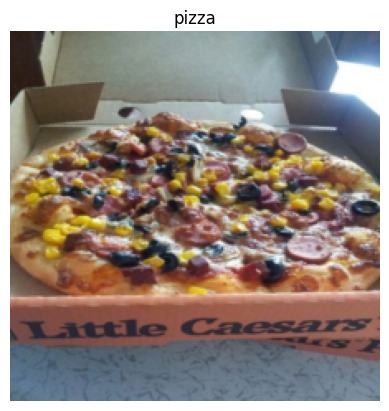

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

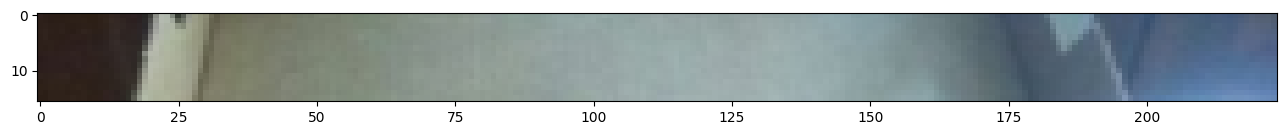

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


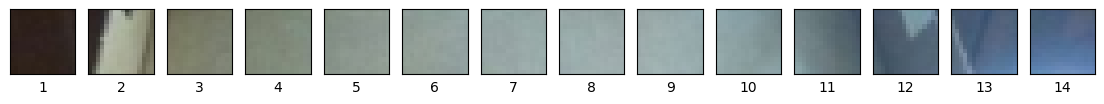

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


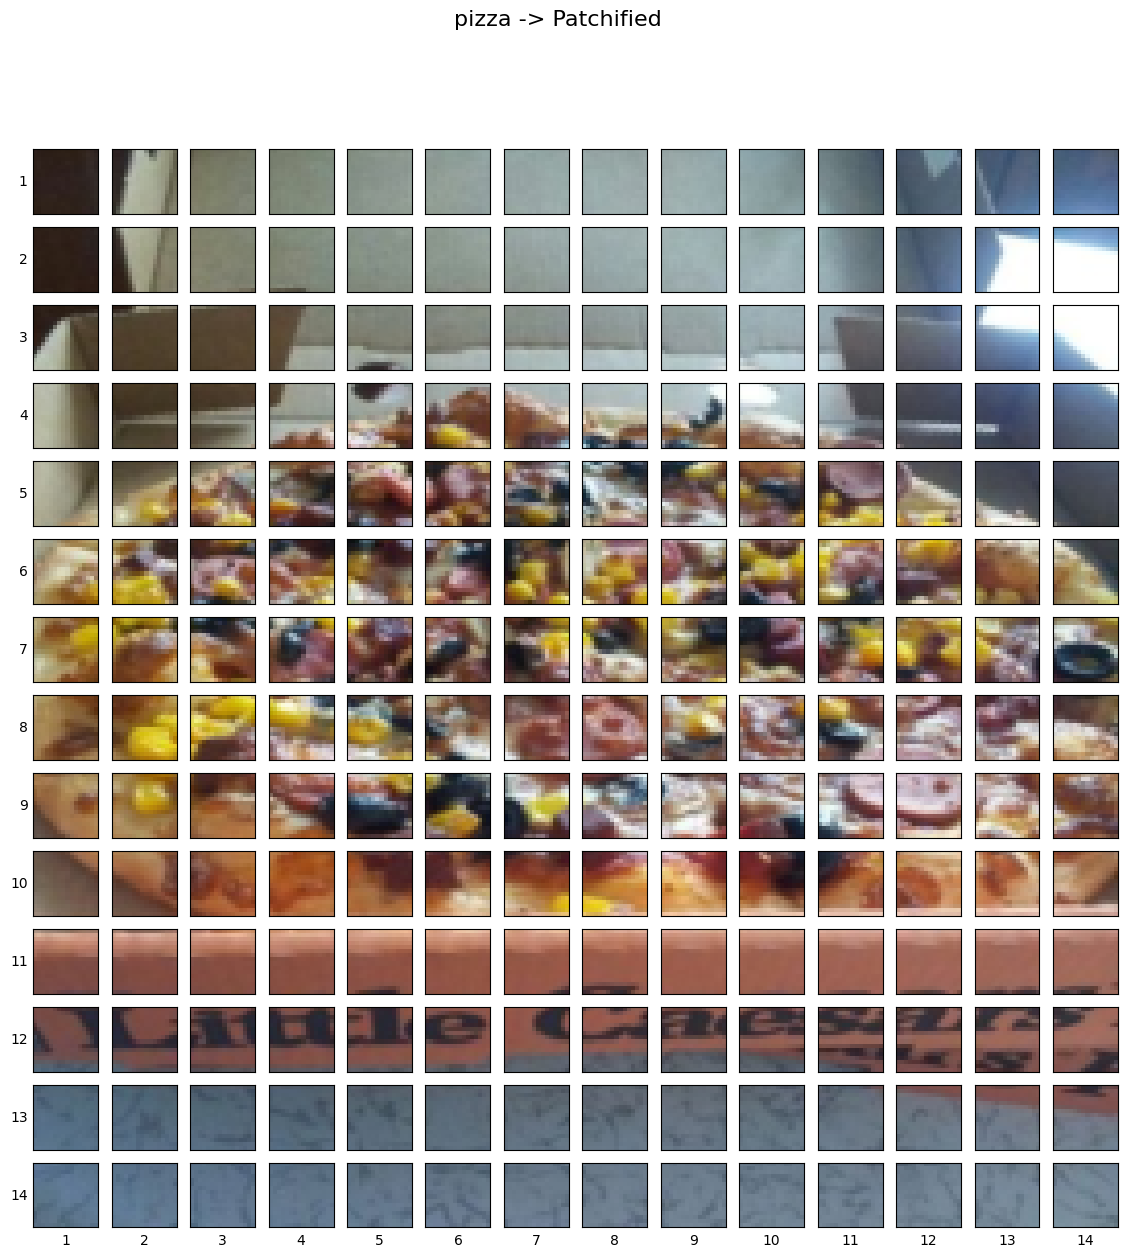

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")


# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d` and setting the kernel size and stride values to `patch_size`.

In [17]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

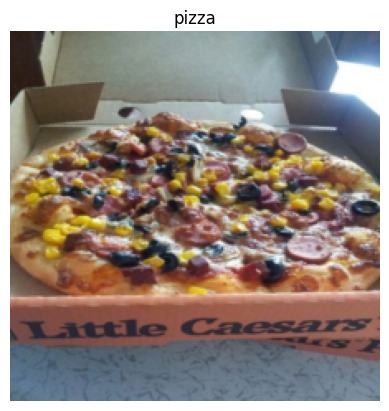

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [359, 315, 591, 535, 389]


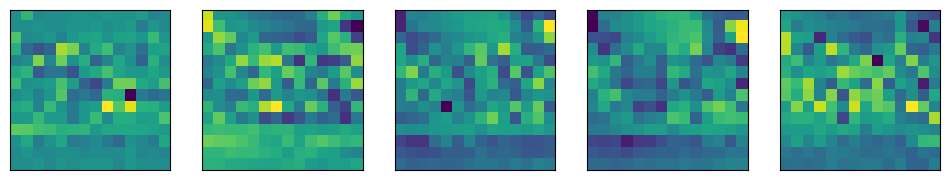

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.0701, 0.0784, 0.1792, 0.2088, 0.2181, 0.2273, 0.2484, 0.2458,
           0.2574, 0.2369, 0.2068, 0.0961, 0.1973, 0.2023],
          [0.0710, 0.1198, 0.1853, 0.1825, 0.2074, 0.2154, 0.2261, 0.2346,
           0.2480, 0.2604, 0.2370, 0.1807, 0.2577, 0.2990],
          [0.1004, 0.0664, 0.1322, 0.1856, 0.1590, 0.2820, 0.2608, 0.2834,
           0.3108, 0.2951, 0.2027, 0.1504, 0.1894, 0.2161],
          [0.2556, 0.1558, 0.1429, 0.0735, 0.1570, 0.1216, 0.2276, 0.0843,
           0.0071, 0.1486, 0.2970, 0.1318, 0.1009, 0.1089],
          [0.2358, 0.2495, 0.0910, 0.0663, 0.2734, 0.0039, 0.1067, 0.1427,
           0.0901, 0.1941, 0.2940, 0.2487, 0.4410, 0.1239],
          [0.0995, 0.3133, 0.0856, 0.1631, 0.3496, 0.1153, 0.1675, 0.1377,
           0.2772, 0.1842, 0.2301, 0.1959, 0.1783, 0.2680],
          [0.2351, 0.1889, 0.1091, 0.3317, 0.1750, 0.2255, 0.1190, 0.3286,
           0.3994, 0.2612, 0.0489, 0.1086, 0.2463, 0.1657],
          [0.1464, 0.1441, 0.0562, 0.3976, 0.2536, 0.16

The `grad_fn` output of the `single_feature_map` and the `requires_grad=True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* **Desried output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

Let's check the current shape.

In [22]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature__map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature__map_width)


What: (batch_size, number_of_pathes, embedding_dim)

In [23]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: tensor([[[0.0701, 0.0784, 0.1792,  ..., 0.1549, 0.1832, 0.2144],
         [0.0063, 0.1801, 0.0879,  ..., 0.0723, 0.0586, 0.0692],
         [0.1801, 0.5399, 0.5099,  ..., 0.4870, 0.4730, 0.5065],
         ...,
         [0.0551, 0.0806, 0.0998,  ..., 0.0842, 0.0910, 0.0757],
         [0.0030, 0.0559, 0.0459,  ..., 0.0516, 0.0327, 0.0520],
         [0.0772, 0.3603, 0.3887,  ..., 0.4892, 0.4770, 0.4695]]],
       grad_fn=<ReshapeAliasBackward0>)


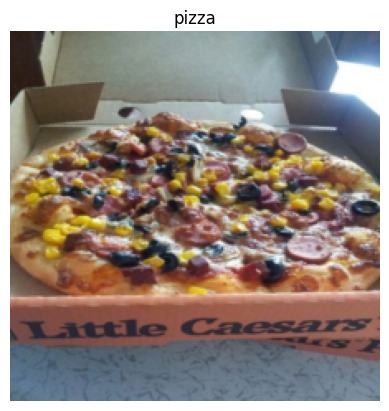

In [24]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened}")

In [25]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, emvedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, emvedding_dimension)


In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map # embedded vector (What the image is represented as)

tensor([[0.0701, 0.0784, 0.1792, 0.2088, 0.2181, 0.2273, 0.2484, 0.2458, 0.2574,
         0.2369, 0.2068, 0.0961, 0.1973, 0.2023, 0.0710, 0.1198, 0.1853, 0.1825,
         0.2074, 0.2154, 0.2261, 0.2346, 0.2480, 0.2604, 0.2370, 0.1807, 0.2577,
         0.2990, 0.1004, 0.0664, 0.1322, 0.1856, 0.1590, 0.2820, 0.2608, 0.2834,
         0.3108, 0.2951, 0.2027, 0.1504, 0.1894, 0.2161, 0.2556, 0.1558, 0.1429,
         0.0735, 0.1570, 0.1216, 0.2276, 0.0843, 0.0071, 0.1486, 0.2970, 0.1318,
         0.1009, 0.1089, 0.2358, 0.2495, 0.0910, 0.0663, 0.2734, 0.0039, 0.1067,
         0.1427, 0.0901, 0.1941, 0.2940, 0.2487, 0.4410, 0.1239, 0.0995, 0.3133,
         0.0856, 0.1631, 0.3496, 0.1153, 0.1675, 0.1377, 0.2772, 0.1842, 0.2301,
         0.1959, 0.1783, 0.2680, 0.2351, 0.1889, 0.1091, 0.3317, 0.1750, 0.2255,
         0.1190, 0.3286, 0.3994, 0.2612, 0.0489, 0.1086, 0.2463, 0.1657, 0.1464,
         0.1441, 0.0562, 0.3976, 0.2536, 0.1664, 0.2006, 0.2130, 0.0599, 0.2120,
         0.2546, 0.2979, 0.3

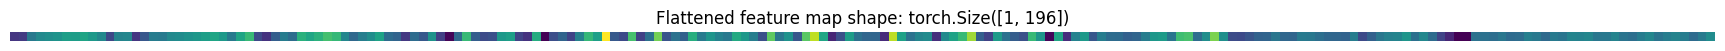

In [27]:
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PathEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, path size.
3. Create a layer to turn an image into embedding pathces using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.


In [28]:
# Step 1. Create a class called PathEmbedding
class PatchEmbedding(nn.Module):
  # Step 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
              in_channels:int=3,
              patch_size:int=16,
              embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    # Step 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # Step 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                              end_dim=3)

  # Step 5. Define the forward method to define the forward computation steps
  def forward(self,x):
    # Create assertion to check that input are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"


    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # Step 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

`PatchEmbedding` layer created!

Try it out on a single image.

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# Create random input sizes
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.rand(1, 3, 250, 250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [31]:
patch_embedded_image.shape # wil change to 197 in the end of the session

torch.Size([1, 196, 768])

In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [33]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [34]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension


# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1826,  0.0203, -0.0561,  ...,  0.1010, -0.0760,  0.0667],
         [-0.7196,  0.1615, -0.2192,  ...,  0.5178, -0.1064,  0.0814],
         ...,
         [-0.5140,  0.1800, -0.1956,  ...,  0.4086, -0.2054,  0.1498],
         [-0.5620,  0.1415, -0.1795,  ...,  0.4230, -0.2051,  0.1731],
         [-0.5243,  0.2046, -0.1920,  ...,  0.4245, -0.2061,  0.2046]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Nice! Learnable class token prepended!

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png" width=900 alt="going from a sequence of patch embeddings, creating a learnable class token and then prepending it to the patch embeddings"/>


### 4.7 Creating the position embedding

What to: Create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [35]:
# View the sequence of patch embeddings with the parepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1826,  0.0203, -0.0561,  ...,  0.1010, -0.0760,  0.0667],
          [-0.7196,  0.1615, -0.2192,  ...,  0.5178, -0.1064,  0.0814],
          ...,
          [-0.5140,  0.1800, -0.1956,  ...,  0.4086, -0.2054,  0.1498],
          [-0.5620,  0.1415, -0.1795,  ...,  0.4230, -0.2051,  0.1731],
          [-0.5243,  0.2046, -0.1920,  ...,  0.4245, -0.2061,  0.2046]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate N (number_of_patches)
number_of_patches = int( (height * width) / patch_size**2)

# Get the embedding dimention
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8174, 1.0203, 0.9439,  ..., 1.1010, 0.9240, 1.0667],
         [0.2804, 1.1615, 0.7808,  ..., 1.5178, 0.8936, 1.0814],
         ...,
         [0.4860, 1.1800, 0.8044,  ..., 1.4086, 0.7946, 1.1498],
         [0.4380, 1.1415, 0.8205,  ..., 1.4230, 0.7949, 1.1731],
         [0.4757, 1.2046, 0.8080,  ..., 1.4245, 0.7939, 1.2046]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings.
Now let's it all in one cell.

In [38]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])



<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png" width=900 alt="mapping equation 1 from the vision transformer paper to pytorch code"/>


<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif" alt="Vision transformer architecture animation, going from a single image and passing it through a patch embedidng layer and then passing it through the transformer encoder." width=900/>

## 5. Equation 2: Multi-Head Attention (MSA)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
* In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
* We want our neual network (ViT) to learn this relationship/representation.

* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
* Normalization = make everything have the same mean and same standard deviation.
* When we normalize along the embedding dimension, it's like making all of the staircase the same size.



Recall equation 2 states:
$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

We'll refer to equation 2 as the "MSA block".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

* **Multi-Head Self Attention (MSA)** - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **Norm (LN or LayerNorm)** - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Residual connection** - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).

### 5.1 The LayerNorm (LN) layer

[Layer Normalization](https://paperswithcode.com/method/layer-normalization) (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

You can find the formal definition of `torch.nn.LayerNorm()` in the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

PyTorch's `torch.nn.LayerNorm()`'s main parameter is `normalized_shape` which we can set to be equal to the dimension size we'd like to noramlize over (in our case it'll be $D$ or `768` for ViT-Base).


### 5.2 The Multi-Head Self Attention (MSA) layer

We're going to focus more on coding an existing PyTorch MSA implementation than creating our own.

However, you can find the formal defintion of the ViT paper's MSA implementation is defined in Appendix A:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png" alt="vision transformer paper figure 1 highlighted with equation 2 and appendix A" width=900/>


We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* `batch_first` - does our batch dimension come first? (yes it does)

### 5.3 Replicating Equation 2 with PyTorch layers

Let's put everything we've discussed about the LayerNorm (LN) and Multi-Head Attention (MSA) layers in equation 2 into practice.

To do so, we'll:  

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate `embed_dim`, `num_heads`, `dropout` and `batch_first` parameters.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MSA layer.

In [39]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self-attention block ("MSA block" for short).
  """
  # 2. Initialize the class with hyperparameters from Table 1
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embdedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
  def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output



In [40]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


The shape did not change, but the values has changed.

In [41]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8174, 1.0203, 0.9439,  ..., 1.1010, 0.9240, 1.0667],
         [0.2804, 1.1615, 0.7808,  ..., 1.5178, 0.8936, 1.0814],
         ...,
         [0.4860, 1.1800, 0.8044,  ..., 1.4086, 0.7946, 1.1498],
         [0.4380, 1.1415, 0.8205,  ..., 1.4230, 0.7949, 1.1731],
         [0.4757, 1.2046, 0.8080,  ..., 1.4245, 0.7939, 1.2046]]],
       grad_fn=<AddBackward0>)

In [42]:
patched_image_through_msa_block

tensor([[[-0.2228, -0.2138,  0.0850,  ..., -0.4666,  0.8914, -0.4850],
         [-0.2203, -0.2072,  0.0881,  ..., -0.4647,  0.8975, -0.4995],
         [-0.2205, -0.2052,  0.0923,  ..., -0.4610,  0.8979, -0.5028],
         ...,
         [-0.2201, -0.2002,  0.0908,  ..., -0.4657,  0.8979, -0.5005],
         [-0.2203, -0.1996,  0.0909,  ..., -0.4666,  0.8976, -0.4999],
         [-0.2196, -0.1996,  0.0912,  ..., -0.4659,  0.8977, -0.5007]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
* MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
* Layers can mean - fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In pyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
* **Dropout**


In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```


Let's keep it going and replicate equation 3:

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png" alt="mapping equation 3 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>


In [43]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [44]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### 7.1 Creating a Transformer Encoder by combining our custom made layers

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`


In [45]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [46]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

So far we've created a transformer encoder by hand.
But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers,

We can create Transformer Encoder with pure PyTorch layers.

In [47]:
# Create the same as above with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table 1
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT


In [49]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [50]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [51]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [52]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model


In [53]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 9. Setting up training code for our ViT model


### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [54]:
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [55]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.
So since it's multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

In [56]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [57]:
from going_modular.going_modular import engine

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


In [58]:
!vidia-smi

/bin/bash: line 1: vidia-smi: command not found


### 9.4 What our training setup is missing

How is our training setip different to the ViT paper?
We've replicated model architecture correctly.
But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?




The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 |
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None |
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None |
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |

Even though our ViT architecture is the same as the paper, the results from the ViT paper were achieved using far more data and a more elaborate training scheme than ours.

Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme such as learning rate warmup, learning rate decay and gradient clipping are specifically designed to [prevent overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting) (regularization).


### 9.5 Plot the loss curves of our ViT model


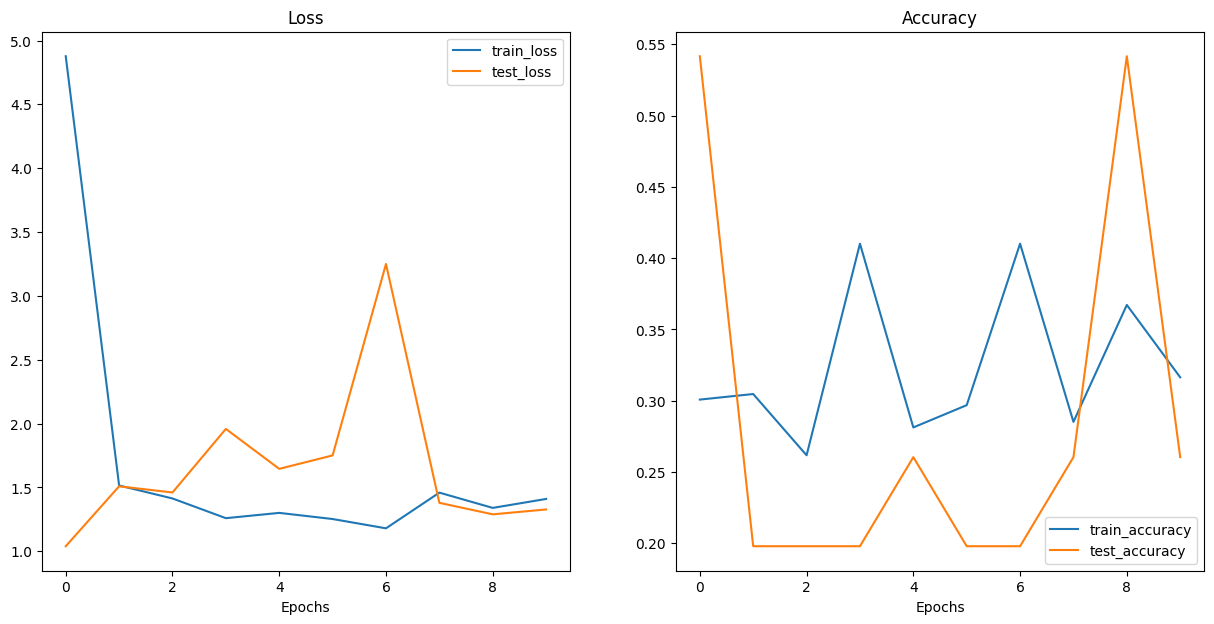

In [59]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

Generally. in deep learning if you can use a pretrained model from a large  dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10. 1 *Why use a pretrained model?*

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes...)

In [60]:
# Cost of a TPUv3 for 30 days
cost = 30*24*8
print(f"Cost of renting a TPUv3 for 30 straight days: {cost} USA")

Cost of renting a TPUv3 for 30 straight days: 5760 USA


In [61]:
# The following requires torchvision v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Getting a pretrained ViT model and creating a feature extractor


In [63]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 127MB/s] 


### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [64]:
# Get automatic transforms from pretrained ViT weioghts
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [65]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [67]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # Could set a higher batch size because using  pretrained model

### 10.4 Train feature extractor ViT model


In [68]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot feature extractor ViT model loss curves


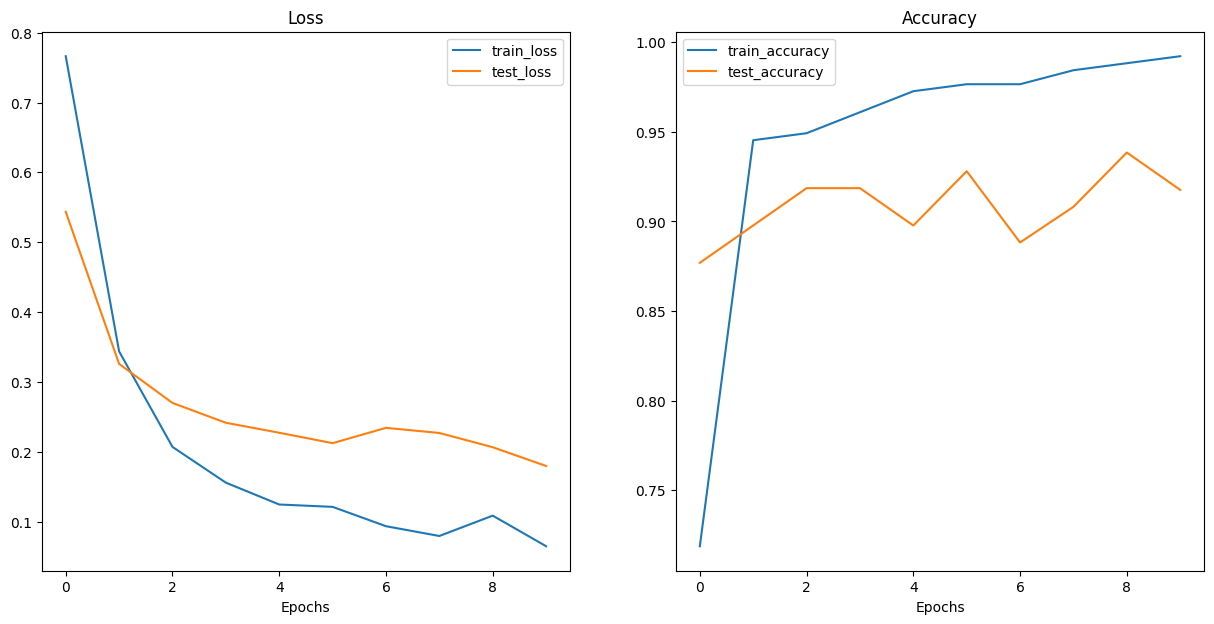

In [69]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save feature extractor ViT model and check file size

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesizee because if we wanted to deploy a model to say a website/mobile application, we may have limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [71]:
# save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [72]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larget than our next best performing model.

Perhaps the largeet model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file/might not make predictions as fast as a smaller model).

## 11. Make predictions on a custom image


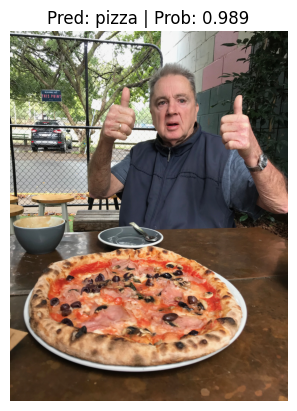

In [73]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)